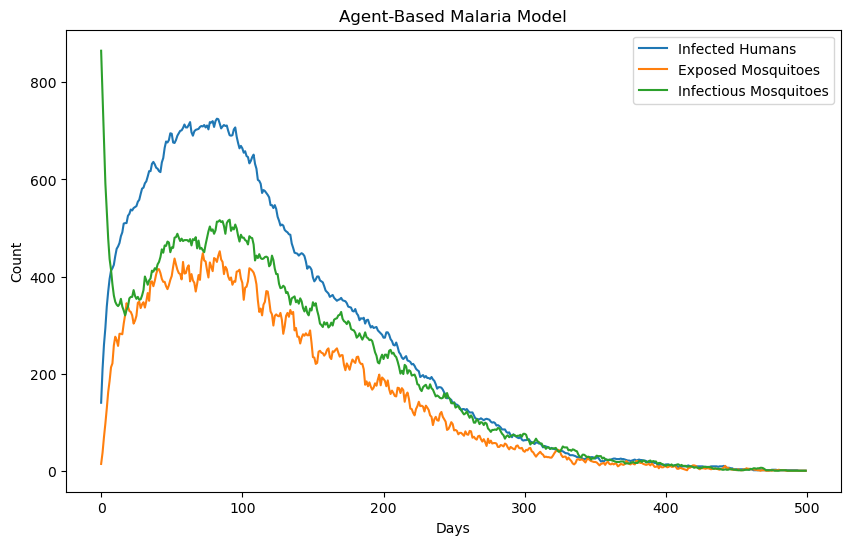

Basic Reproduction Number R0: 1.68
Peak Infected Humans: 725 on day 82


In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 10000  # Total human population
T = 28      # Temperature in Celsius
m = 1       # Mosquito-to-human ratio
days = 500  # Simulation duration

# Derived parameters
a = max(0, 0.017*T - 0.165)  # Biting rate
b = 0.35     # Transmission human to mosquito
c = 0.5      # Transmission mosquito to human
r = 0.05     # Human recovery rate
mu_2 = 1/(-0.03*(T**2) + 1.31*T - 4.4)  # Mosquito mortality
tau_m = int(747.55*np.exp(-0.239*T) + 5.06)  # Mosquito latent period

# Initialize populations
humans = ['S']*(N-50) + ['I']*50 + ['R']*0  # Start with 50 infected
mosquitoes = []
for _ in range(int(N*m)):
    if random.random() < 0.05:
        mosquitoes.append({'state': 'I', 'exposed_day': None})
    elif random.random() < 0.05:
        mosquitoes.append({'state': 'E', 'exposed_day': -tau_m})
    else:
        mosquitoes.append({'state': 'S', 'exposed_day': None})

# Tracking lists
Sc, Ic, Rc = [], [], []
Emc, Imc = [], []

for day in range(days):
    # Update mosquito states
    new_mosquitoes = []
    for mos in mosquitoes:
        # Handle mortality
        if random.random() < mu_2:
            continue
        
        # Handle state transitions
        if mos['state'] == 'E' and day - mos['exposed_day'] >= tau_m:
            mos['state'] = 'I'
        new_mosquitoes.append(mos)
    
    # Maintain mosquito population
    target_mos = int(N*m)
    while len(new_mosquitoes) < target_mos:
        new_mosquitoes.append({'state': 'S', 'exposed_day': None})
    mosquitoes = new_mosquitoes[:target_mos]

    # Mosquito biting process
    new_humans = humans.copy()
    for mos in mosquitoes:
        if mos['state'] == 'I' and random.random() < a:
            # Mosquito bites random human
            idx = random.randint(0, N-1)
            if new_humans[idx] == 'S' and random.random() < b:
                new_humans[idx] = 'I'
        
        if mos['state'] == 'S' and random.random() < a:
            # Mosquito bites random human
            idx = random.randint(0, N-1)
            if new_humans[idx] == 'I' and random.random() < c:
                mos['state'] = 'E'
                mos['exposed_day'] = day
    
    # Human recovery process
    humans = []
    for h in new_humans:
        if h == 'I' and random.random() < r:
            humans.append('R')
        else:
            humans.append(h)
    
    # Track statistics
    Sc.append(humans.count('S'))
    Ic.append(humans.count('I'))
    Rc.append(humans.count('R'))
    Emc.append(sum(1 for m in mosquitoes if m['state'] == 'E'))
    Imc.append(sum(1 for m in mosquitoes if m['state'] == 'I'))

# Plot results
plt.figure(figsize=(10,6))
plt.plot(Ic, label='Infected Humans')
plt.plot(Emc, label='Exposed Mosquitoes')
plt.plot(Imc, label='Infectious Mosquitoes')
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Agent-Based Malaria Model')
plt.legend()
plt.show()

# Calculate R0
R0 = (m*(a**2)*b*c*np.exp(-mu_2*tau_m))/(r*mu_2)
print(f"Basic Reproduction Number R0: {R0:.2f}")
print(f"Peak Infected Humans: {max(Ic)} on day {np.argmax(Ic)}")

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import lru_cache

class LocationCache:
    def __init__(self):
        self.human_cache = defaultdict(set)
        self.mosq_cache = defaultdict(set)
        self.invalidations = 0
        
    def invalidate(self, net_type, node_id):
        key = (net_type, node_id)
        if key in self.human_cache:
            del self.human_cache[key]
        if key in self.mosq_cache:
            del self.mosq_cache[key]
        self.invalidations += 1

class Network:
    def __init__(self, name):
        self.name = name
        self.nodes = defaultdict(lambda: {
            'agents': set(),
            'stats': {
                'infections': [],
                'mosq_count': [],
                'human_count': []
            }
        })
        self.breeding_data = {}
        
    def add_node(self, node_id, is_breeding_site=False):
        self.nodes[node_id]['agents'] = set()
        if is_breeding_site:
            self.breeding_data[node_id] = {'larvae': 0}
            
    def update_larvae(self, node_id, temperature):
        if node_id in self.breeding_data:
            development_rate = max(0, 0.01 * temperature - 0.1)
            self.breeding_data[node_id]['larvae'] *= (1 + development_rate)
            
    def record_stats(self, node_id):
        stats = self.nodes[node_id]['stats']
        agents = self.nodes[node_id]['agents']
        stats['human_count'].append(sum(1 for a in agents if a < 5000))
        stats['mosq_count'].append(sum(1 for a in agents if a >= 5000))
        stats['infections'].append(0)

class Human:
    def __init__(self, uid, sim):
        self.id = uid
        self.state = 'S'
        self.locations = {
            'home': None,
            'work': None,
            'social': None
        }
        self.current_net = None
        self._current_node = None
        self.exposed_day = -1
        self.infected_day = -1
        self.age = random.randint(0, 80)
        self.immune_duration = 365
        self.uses_bednet = random.random() < 0.6
        self.sim = sim
        
    @property
    def current_node(self):
        return self._current_node
    
    @current_node.setter
    def current_node(self, value):
        # Invalidate the cache if the node changes
        if self._current_node != value and self._current_node is not None:
            self.sim.cache.invalidate(self.current_net.name, self._current_node)
        self._current_node = value
        
    def move(self, network_name, network, node_id):
        old_net = self.current_net
        old_node = self.current_node
        # Remove from old location
        if old_net is not None and old_node is not None:
            old_net.nodes[old_node]['agents'].discard(self.id)
        # Assign new location
        self.current_net = network
        self.current_node = node_id
        network.nodes[node_id]['agents'].add(self.id)

class Mosquito:
    def __init__(self, uid, sim):
        self.id = uid
        self.state = 'S'
        self.current_net = None
        self._current_node = None
        self.exposed_day = -1
        self.age = 0
        self.max_age = 30
        self.sim = sim
        
    @property
    def current_node(self):
        return self._current_node
    
    @current_node.setter
    def current_node(self, value):
        # Invalidate the cache if the node changes
        if self._current_node != value and self._current_node is not None:
            self.sim.cache.invalidate(self.current_net.name, self._current_node)
        self._current_node = value
        
    def move(self, network, node_id):
        old_net = self.current_net
        old_node = self.current_node
        # Remove from old location
        if old_net is not None and old_node is not None:
            old_net.nodes[old_node]['agents'].discard(self.id)
        # Assign new location
        self.current_net = network
        self.current_node = node_id
        network.nodes[node_id]['agents'].add(self.id)

class MalariaSimulation:
    def __init__(self, temp=28):
        self.temp = temp
        self.day = 0
        self.humans = []
        self.mosquitoes = []
        self.cache = LocationCache()
        self.location_history = defaultdict(lambda: {
            'infections': [],
            'human_density': [],
            'mosq_density': []
        })
        
        # Initialize networks
        self.networks = {
            'Houses': Network("Houses"),
            'Workplaces': Network("Workplaces"),
            'Social': Network("Social"),
            'BreedingSites': Network("BreedingSites")
        }
        
        # Create nodes
        for i in range(200):
            self.networks['Houses'].add_node(i)
        for i in range(30):
            self.networks['Workplaces'].add_node(i)
        for i in range(10):
            self.networks['Social'].add_node(i)
        for i in range(50):
            self.networks['BreedingSites'].add_node(i, True)
        
        # Temperature-dependent parameters
        self.a = 0.22 * (temp - 16) if 16 < temp < 36 else 0
        self.b = 0.25 + 0.02 * (temp - 25)
        self.c = 0.45 + 0.01 * (temp - 25)
        self.human_incubation = 7
        self.recovery_rate = 0.07
        self.mosq_incubation = max(1, int(4.9 + 35.4 / (temp - 14.6)))
        self.mosq_mortality = 0.25 - 0.008 * temp
        
        # Initialize populations
        self.init_populations()
        
        # Prepare data tracking
        self.setup_data_tracking()
        
    def setup_data_tracking(self):
        self.history = {
            'S': [], 'E': [], 'I': [], 'R': [],
            'mosq_E': [], 'mosq_I': [],
            'human_pop': [], 'mosq_pop': []
        }
        
    def init_populations(self):
        # Initialize humans
        for i in range(5000):
            human = Human(i, self)
            home = random.choice(list(self.networks['Houses'].nodes.keys()))
            # Only assign work if adult
            work = random.choice(list(self.networks['Workplaces'].nodes.keys())) if human.age >= 18 else None
            social = random.choice(list(self.networks['Social'].nodes.keys()))
            
            human.locations = {
                'home': (self.networks['Houses'].name, self.networks['Houses'], home),
                'work': (self.networks['Workplaces'].name, self.networks['Workplaces'], work) if work else None,
                'social': (self.networks['Social'].name, self.networks['Social'], social)
            }
            # Move initially to home
            human.move(*human.locations['home'])
            
            # Infect a small initial subset
            if i < 10:
                human.state = 'I'
                human.infected_day = 0
                
            self.humans.append(human)
        
        # Initialize mosquitoes
        for i in range(10000):
            mosq = Mosquito(5000 + i, self)
            site = random.choice(list(self.networks['BreedingSites'].nodes.keys()))
            mosq.move(self.networks['BreedingSites'], site)
            self.mosquitoes.append(mosq)
            
    def simulate_mosquito_breeding(self):
        for site in self.networks['BreedingSites'].breeding_data:
            larvae = self.networks['BreedingSites'].breeding_data[site]['larvae']
            # Simple development rate estimate
            development_rate = min(1, 0.02 * self.temp - 0.2)
            new_adults = int(larvae * development_rate)
            
            # Spawn new adults
            for _ in range(new_adults):
                new_id = 10000 + len(self.mosquitoes)  # Continue numbering
                mosq = Mosquito(new_id, self)
                mosq.move(self.networks['BreedingSites'], site)
                self.mosquitoes.append(mosq)
            
            # Add new larvae
            adults = len(self.networks['BreedingSites'].nodes[site]['agents'])
            self.networks['BreedingSites'].breeding_data[site]['larvae'] += adults * 50
    
    @lru_cache(maxsize=1000)
    def get_agents_cached(self, net_type, node_id):
        net = self.networks[net_type]
        agents = net.nodes[node_id]['agents']
        humans = [a for a in agents if a < 5000]
        mosquitoes = [a for a in agents if a >= 5000]
        return humans, mosquitoes
    
    def handle_movement(self):
        # Hour of the day (though we step daily, we break transmissions by hours)
        current_hour = (self.day * 24) % 24
        
        # Humans
        for human in self.humans:
            if human.age < 18:
                # Children move to social occasionally in the day
                if 8 <= current_hour < 15 and random.random() < 0.3:
                    human.move(*human.locations['social'])
                else:
                    human.move(*human.locations['home'])
            else:
                # Adults - typical work hours, else home
                if 8 <= current_hour < 17:
                    dest = human.locations['work'] if random.random() < 0.7 else human.locations['social']
                else:
                    dest = human.locations['home']
                if dest:
                    human.move(*dest)
        
        # Mosquitoes
        for mosq in self.mosquitoes:
            # Move to houses/social in dusk/dawn windows
            if 18 <= current_hour < 22 or 4 <= current_hour < 8:
                if random.random() < 0.4:
                    new_net = random.choice([self.networks['Houses'], self.networks['Social']])
                    new_node = random.choice(list(new_net.nodes.keys()))
                    mosq.move(new_net, new_node)
    
    def transmission_phase(self):
        # a_hourly is bite rate per hour
        a_hourly = self.a / 24
        
        for mosq in self.mosquitoes:
            if mosq.current_net and mosq.current_node is not None:
                net_name = mosq.current_net.name
                node_id = mosq.current_node
                humans, _ = self.get_agents_cached(net_name, node_id)
                
                # Slightly higher risk if there's a child under 5 around
                age_risk = 1.5 if any(self.humans[h].age < 5 for h in humans) else 1.0
                
                # Infect humans
                if mosq.state == 'I' and random.random() < a_hourly:
                    for h_id in humans:
                        human = self.humans[h_id]
                        if human.state != 'S':
                            continue
                        # If at home and uses a bednet, reduce infection chance
                        bednet = (human.uses_bednet and human.current_net.name == 'Houses')
                        prob = self.b * (0.3 if bednet else 1.0) * age_risk
                        if random.random() < prob:
                            human.state = 'E'
                            human.exposed_day = self.day
                            # Record infection event
                            self.networks[net_name].nodes[node_id]['stats']['infections'][-1] += 1
                
                # Mosquito becomes infected
                elif mosq.state == 'S' and random.random() < a_hourly:
                    infected = any(self.humans[h_id].state == 'I' for h_id in humans)
                    if infected and random.random() < self.c:
                        mosq.state = 'E'
                        mosq.exposed_day = self.day
    
    def update_states(self):
        # Humans
        new_humans = []
        for h in self.humans:
            # Exposed -> Infected
            if h.state == 'E' and (self.day - h.exposed_day) >= self.human_incubation:
                h.state = 'I'
                h.infected_day = self.day
            # Infected -> Recovered
            elif h.state == 'I' and random.random() < self.recovery_rate:
                h.state = 'R'
            # Recovered -> Susceptible after immunity ends
            elif h.state == 'R' and (self.day - h.infected_day) > h.immune_duration:
                h.state = 'S'
                
            # Death check
            base_mortality = 0.0001 + (0.001 if h.state == 'I' else 0)
            # Extra risk for older (>70) or very young (<5)
            age_mortality = 0.002 if h.age > 70 else 0.0005 if h.age < 5 else 0
            total_mort = base_mortality + age_mortality
            # Survives if random() > total_mort
            if random.random() > total_mort:
                new_humans.append(h)
        self.humans = new_humans
        
        # Mosquito breeding each day
        self.simulate_mosquito_breeding()
        
        # Mosquitoes
        new_mosquitoes = []
        for m in self.mosquitoes:
            m.age += 1
            # Death check
            if m.age > m.max_age or random.random() < self.mosq_mortality:
                continue
            # Exposed -> Infectious
            if m.state == 'E' and (self.day - m.exposed_day) >= self.mosq_incubation:
                m.state = 'I'
            new_mosquitoes.append(m)
        self.mosquitoes = new_mosquitoes
    
    def track_location_dynamics(self):
        for net_name, net in self.networks.items():
            for node_id in net.nodes:
                humans, mosquitoes = self.get_agents_cached(net_name, node_id)
                key = (net_name, node_id)
                
                self.location_history[key]['infections'].append(
    sum(1 for h in humans if h < len(self.humans) and self.humans[h].state == 'I')
)

                self.location_history[key]['human_density'].append(len(humans))
                self.location_history[key]['mosq_density'].append(len(mosquitoes))
                
                net.record_stats(node_id)
    
    def step(self):
        # Move everyone for the current day
        self.handle_movement()
        
        # Hourly transmission steps (24 times a day)
        for _ in range(24):
            self.transmission_phase()
        
        # Update disease states
        self.update_states()
        
        # Track location-based data
        self.track_location_dynamics()
        
        # Record daily stats
        self.record_stats()
        
        # Advance day
        self.day += 1
    
    def record_stats(self):
        states = defaultdict(int)
        for h in self.humans:
            states[h.state] += 1
        self.history['S'].append(states['S'])
        self.history['E'].append(states['E'])
        self.history['I'].append(states['I'])
        self.history['R'].append(states['R'])
        
        e_mosq = sum(1 for m in self.mosquitoes if m.state == 'E')
        i_mosq = sum(1 for m in self.mosquitoes if m.state == 'I')
        self.history['mosq_E'].append(e_mosq)
        self.history['mosq_I'].append(i_mosq)
        self.history['human_pop'].append(len(self.humans))
        self.history['mosq_pop'].append(len(self.mosquitoes))
    
    def plot_results(self):
        plt.figure(figsize=(12, 6))
        days = np.arange(len(self.history['S']))
        
        plt.stackplot(days, self.history['S'], self.history['E'], 
                      self.history['I'], self.history['R'],
                      labels=['Susceptible', 'Exposed', 'Infected', 'Recovered'])
        plt.xlabel('Days')
        plt.ylabel('Human Population')
        plt.legend(loc='upper left')
        
        # Plot mosquito data on secondary y-axis
        plt.twinx()
        plt.plot(days, self.history['mosq_I'], 'r--', label='Infectious Mosquitoes')
        plt.ylabel('Mosquito Population')
        plt.legend(loc='upper right')
        plt.title('Malaria Transmission Dynamics with Location Tracking')
        plt.show()
    
    def plot_location_heatmap(self, day=-1):
        # House infections
        house_infections = {
            node: data['infections'][day] 
            for (net, node), data in self.location_history.items()
            if net == "Houses"
        }
        
        plt.figure(figsize=(10, 6))
        nodes = list(house_infections.keys())
        infections = list(house_infections.values())
        
        # Simple scatter with row/col arrangement
        plt.scatter(
            [n % 20 for n in nodes],   # X coordinate
            [n // 20 for n in nodes],  # Y coordinate
            c=infections,
            cmap='Reds',
            s=100,
            edgecolor='k'
        )
        plt.colorbar(label='Active Infections')
        plt.title(f'Infection Heatmap on Day {self.day if day == -1 else day}')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.grid(True)
        plt.show()

# Run the simulation
sim = MalariaSimulation(temp=28)
for _ in range(90):
    sim.step()

# Generate overall plots
sim.plot_results()
sim.plot_location_heatmap(day=30)
sim.plot_location_heatmap(day=60)
sim.plot_location_heatmap(day=90)

# Print cache performance
print(f"Cache invalidations: {sim.cache.invalidations}")
print(f"Cache hits: {sim.get_agents_cached.cache_info().hits}")

# Example of accessing house node 42 data
house_data = sim.location_history[('Houses', 42)]

# Plot infection timeline for workplace node 5
plt.plot(sim.networks['Workplaces'].nodes[5]['stats']['infections'])
plt.title("Daily Infections at Workplace 5")
plt.show()

# Compare total mosquito densities across breeding sites
breeding_densities = {
    node: sum(data['mosq_density'])
    for (net, node), data in sim.location_history.items()
    if net == "BreedingSites"
}
